# Analiza eksperymentu A/B na podstawie logów

* Logi z serwisu zawierają dla każdej predykcji
  * id użytkownika
  * użyty model
  * id listingu
  * wartość predykcji
  * parametry wywołania
* Na podstawie id oferty wyszukujemy rzeczywistą ocenę w zbiorze testowym

## Opis eksperymentu
* Na podstawie zbioru testowego wysyłamy zapytania do serwisu predykcyjnego
* Zbieramy logi z serwisu
* Na podstawie błędu kwadratowego predykcji porównujemy jakość modeli

In [45]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

EXPERIMENT_SET = "../data/processed/experiment_set.csv"
LOG_FILE = "../data/service.log"
BASE_MODEL_NAME = "RandomBaseModel"
NEW_MODEL_NAME = "NeuralNetPredictionModel"

## Przetwarzanie logów

In [46]:
regex = re.compile(
    r"Predicted (?P<prediction>[0-9.]+) for user (?P<user_id>[a-f0-9\-]+), using model (?P<model_name>\w+), given params: (?P<params>\{.*\})")


def parse_log_line(log_line: str):
    log_line = log_line.strip()
    parsed = re.search(regex, log_line).groupdict()
    params_dict = json.loads(parsed["params"])
    parsed.pop("params")
    for key, val in params_dict.items():
        parsed[key] = val

    return parsed


with open(LOG_FILE) as f:
    logs = pd.DataFrame([
        parse_log_line(line)
        for line in f
        if "PredictionService" in line
    ])

In [47]:
logs = logs.loc[:, ["prediction", "model_name", "id"]]
logs.loc[:, "id"] = logs["id"].astype(int)
logs["prediction"] = pd.to_numeric(logs["prediction"])

In [48]:
test_set = pd.read_csv(EXPERIMENT_SET)
test_set = test_set[["id", "avg_rating"]]
test_set.rename(columns={"avg_rating": "real_rating"}, inplace=True)

In [49]:
logs = logs.merge(test_set, on="id", how="left")
logs["squared_error"] = ((logs["prediction"] - logs["real_rating"]) ** 2)

In [50]:
logs

,prediction,model_name,id,real_rating,squared_error
0,4.982276,RandomBaseModel,1028233458536518838,4.875714,0.011355
1,4.789342,RandomBaseModel,12053231,4.285714,0.253641
2,4.934319,RandomBaseModel,54035917,4.611429,0.104258
3,4.355471,RandomBaseModel,9993168,4.715714,0.129775
4,4.764409,RandomBaseModel,9655481,4.904286,0.019565
...,...,...,...,...,...
4277,4.827282,NeuralNetPredictionModel,21812927,4.778571,0.002373
4278,4.833619,NeuralNetPredictionModel,35405882,4.971429,0.018991
4279,4.835393,NeuralNetPredictionModel,8736714,5.000000,0.027095
4280,4.886052,NeuralNetPredictionModel,38892522,4.694286,0.036774


In [51]:
logs_a = logs[logs["model_name"] == NEW_MODEL_NAME]
logs_b = logs[logs["model_name"] == BASE_MODEL_NAME]

## Wizualizacja wyników

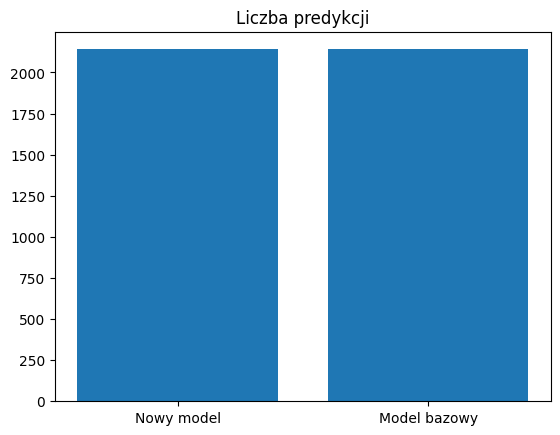

In [52]:
plt.bar(x=["Nowy model", "Model bazowy"], height=[len(logs_a), len(logs_b)])
plt.title("Liczba predykcji")
plt.show()

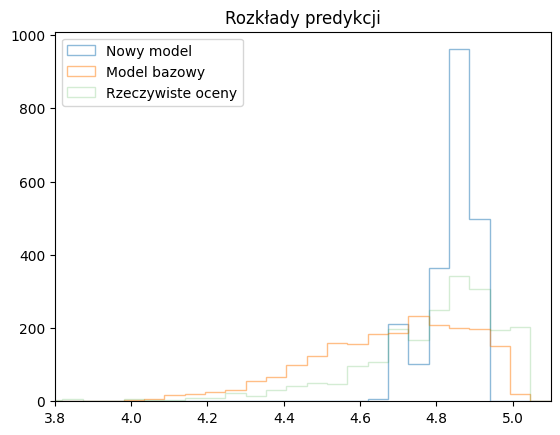

In [57]:
plt.hist(logs_a["prediction"].astype(float), range=(3.5,5.1), histtype="step", bins=30, alpha=0.5, label="Nowy model")
plt.hist(logs_b["prediction"].astype(float), range=(3.5,5.1), histtype="step", bins=30, alpha=0.5, label="Model bazowy")
plt.hist(logs_a["real_rating"].astype(float), range=(3.5,5.1), histtype="step", bins=30, alpha=0.2, label="Rzeczywiste oceny")
plt.legend()
plt.title("Rozkłady predykcji")
plt.xlim(3.8, 5.1)
plt.show()

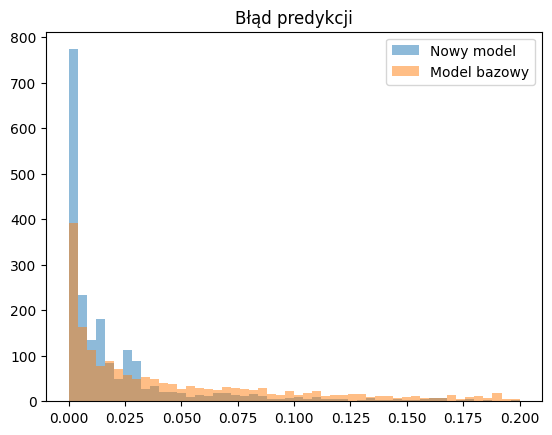

In [54]:
plt.hist(logs_a["squared_error"], range=(0, 0.2), bins=50, alpha=0.5, label="Nowy model")
plt.hist(logs_b["squared_error"], range=(0, 0.2), bins=50, alpha=0.5, label="Model bazowy")
plt.legend()
plt.title("Błąd predykcji")
plt.show()

## Test statystyczny

### Hipotezy

* $H_0$: Nowy model (A) nie jest lepszy od modelu bazowego (B)
* $H_1$: Nowy model (A) jest lepszy od modelu bazowego (B)
* Porównujemy błędy średniokeadratowego - mniejszy błąd oznacza lepszy model

$$ H_0: err_A \ge err_B $$

$$ H_1: err_A < err_B $$

### Test
* Wykorzystamy test t-Studenta dla dwóch prób
* Przyjmujemy poziom istotności $\alpha = 0.05$
* P-wartość oznacza prawdopodobieństwo obserwacji wyników, w świecie, w którym hipoteza zerowa jest prawdziwa.
* Jeśli p-wartość jest mniejsza od poziomu istotności, to odrzucamy hipotezę zerową.

In [55]:
alpha = 0.05
t_stat, p_value = ttest_rel(logs_a["squared_error"], logs_b["squared_error"])
print(f"Alpha: {alpha}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject H0, p<alpha, new model is better")
else:
    print("Fail to reject H0, p>=alpha, new model is not better")

Alpha: 0.05
t-statistic: -13.9206
p-value: 0.0000
Reject H0, p<alpha, new model is better


Ponieważ $p \ll \alpha$, odrzucamy hipotezę zerową i przyjmujemy, że nowy model jest lepszy od modelu bazowego.